Based on a post @ [Towards Data Science](https://towardsdatascience.com/time-series-forecasting-using-a-seasonal-arima-model-57127cb8b655).

## SARIMA

<u>Seasonal Auto-Regressive Integrated Moving Average</u>: "accounts for seasonality when generating time series forecasts."

### Algorithm Background

How the ARIMA model works:

**Steps**:

1. "Differencing lagged readings in a time series, consequently making the time series stationary."
2. "Using a specified number of lagged observations in a time series to predict future behavior of a time series. This step comprises a combination of two models: the autoregressive (AR) model, and the moving average (MA) model."

**AR model**:

"\[F\]orecasts a variable using a linear combination of its previous values" [[1]](https://otexts.com/fpp2/AR.html).

An AR model of order $p$:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_{p} y_{t-p} + \epsilon_t.
$$

where $\epsilon_t$ represents a random error term, $y_{t-p}$ represents the $p$-th previous value and $phi_i$ are constant. 

> "The $\phi$ value decreases as it moves further from point $t$, the latest value in the sequence. Consequently, the closer a lagged value is to the prediction value (at sequence number $t$), the greater the $\phi$ value, and the more influence the time step has on the forecast."

**MA model**:

"\[R\]esembles an AR model, except it is a linear combination of previous error terms" [[2]](https://newonlinecourses.science.psu.edu/stat510/lesson/2/2.1) [[3]](https://otexts.com/fpp2/MA.html).

$$
y_t = \epsilon_t + \phi_1 \epsilon_{t-1} + \phi_1^2 \epsilon_{t-2} + \phi_1^3 \epsilon_{t-3} + ...
$$

**ARIMA Model Parameters**:

[[4]](https://people.duke.edu/~rnau/411arim.htm)

- $p$: "The order of the <u>autoregressive</u> model (the number of lagged terms)";

- $q$ : "The order of the <u>moving average</u> model (the number of lagged terms), described in the MA equation above";

- $d$: "The number of differences required to make the time series stationary".

**SARIMA Model Parameters**:

"The SARIMA model builds upon the ARIMA model. It includes the p, q, and d parameters, but also an extra set of parameters to account for time series seasonality" [[5]](https://online.stat.psu.edu/stat510/lesson/4/4.1).

- $m$: "The seasonality of the model. For example, if the seasonality of a time series repeats yearly, then $m = 12$. If the seasonality is quarterly, then $m = 4$ (meaning the seasonal pattern repeats once every four months)."

**The Time Series**:

"\[W\]e will use the monthly time series for electricity net generation from geothermal energy in the United States. The data can be pulled directly into Python via the Energy Information Administration’s (EIA) API" (see tutorial [here](https://techrando.com/2019/06/26/how-to-use-the-eia-api-to-pull-live-data-directly-into-python/)).

"We use the code below to retrieve and visualize our time series:"

In [1]:
import eia
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def retrieve_time_series(api, series_ID):
    """
    Return the time series dataframe, based on API and unique Series ID
    """
    #Retrieve Data By Series ID 
    series_search = api.data_by_series(series=series_ID)
    ##Create a pandas dataframe from the retrieved time series
    df = pd.DataFrame(series_search)
    return df

def plot_data(df, x_variable, y_variable, title):
    """
    Plot the x- and y- variables against each other, where the variables are columns in
    a pandas dataframe
    Args:
        df: Pandas dataframe. 
        x_variable: String. Name of x-variable column
        y_variable: String. Name of y-variable column
        title: String. Desired title name
    """
    fig, ax = plt.subplots()
    ax.plot_date(df[x_variable], 
                 df[y_variable], marker='', linestyle='-', label=y_variable)
    fig.autofmt_xdate()
    plt.title(title)
    plt.show()

C:\Users\BigData\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


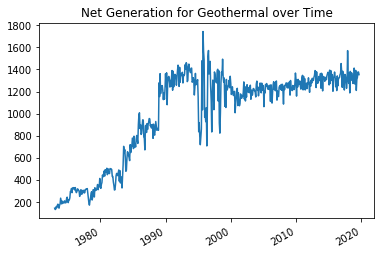

In [3]:
#### EXECUTE IN MAIN FUNCTION ####
#Create EIA API using your specific API key
api_key = "300cbb4456657fe555c5fadf4dc1290c" ###SIGN UP ON THE EIA WEBSITE TO GET A FREE API KEY
api = eia.API(api_key)
#Declare desired series ID
series_ID='TOTAL.GEEGPUS.M'
df = retrieve_time_series(api, series_ID)
df.reset_index(level=0, inplace=True)
df.rename(columns={'index':'Date',
                   df.columns[1]:'Geothermal_net_generation'}, inplace=True)
#Convert the Date column into a date object
df['Date'] = df['Date'].str.rstrip()
df['Date'] = df['Date'].str.replace(' ', '-')
df['Date']=pd.to_datetime(df['Date'], format='%Y-%m')
#Plot the time series
plot_data(df, 'Date', 
          'Geothermal_net_generation', 
          'Net Generation for Geothermal over Time')

"Before we generate a SARIMA model, let’s decompose the time series to ensure it displays seasonality. We use the `seasonal_decompose` function, available via the `statsmodels.tsa` package. This function allows us to break the time series down into its trend, seasonal, and residual components":

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_time_series(series, frequency):
    """
    Decompose a time series and plot it in the console
    Arguments: 
        series: series. Time series that we want to decompose
    Outputs: 
        Decomposition plot in the console
    """
    result = seasonal_decompose(series, model='additive', freq = frequency)
    result.plot()
    plt.show()

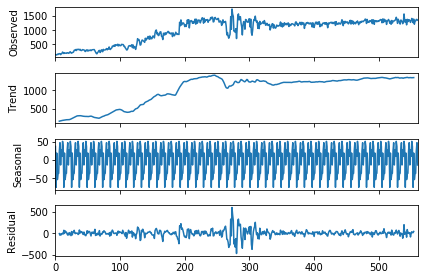

In [5]:
### EXECUTE IN MAIN FUNCTION ###
#Decompose the time series to determine seasonality/trend
decompose_time_series(df['Geothermal_net_generation'], 12)

"As you can see in the graphic above, the time series definitely displays seasonality, with a pattern recurrence occurring once every 12 months (yearly)".

### Building the SARIMA Model

**Hyperparameter selection**:

"We select the $p$, $d$, $q$, $P$, $D$, and $Q$ hyperparameters that best fit the SARIMA model largely through brute force - we sample different model hyperparameter variations until we find the best model combination."

- "After generating each model, we use its AIC and BIC scores to gauge its performance":
    - "The <u>AIC</u>, or the <u>Akaike information criterion</u>, is a metric that compares the quality of a set of statistic models against one another" [[6]](https://www.statisticshowto.datasciencecentral.com/akaikes-information-criterion/).
    - "\[T\]he <u>BIC</u>, or <u>Bayesian Information Criterion</u>, is a Bayesian statistic used to compare different models" [[7]](https://www.statisticshowto.datasciencecentral.com/bayesian-information-criterion/).
- "When comparing models using AIC or BIC metrics, we take the model with the lowest AIC and BIC score as the best option".

In [6]:
import itertools

def sarima_parameter_search(search_range, seasonal = [12]):
    """
    Get all of the parameter combinations for a SARIMA model.
    """
    p = q = d = range(0, search_range)
    trend = ['n','c','t','ct']
    pdq = list(itertools.product(p, d, q))
    pdq_combinations = [(x[0], x[1], x[2], x[3], x[4]) for x in list(itertools.product(p, d, q, seasonal, trend))]
    return pdq, pdq_combinations

In [7]:
### EXECUTE IN MAIN FUNCTION ###
order_combos, seasonal_order_combos = sarima_parameter_search(search_range = 2)

"In the above code snippet, we use the `sarima_parameter_search()` function to generate a list of different hyperparameter combinations, returned as the `pdq_combinations` and `pdq` variables".

- "The seasonal variable, set at a default value of $12$, indicates that the seasonal pattern repeats once every 12 months (yearly)".

"The trend variable has 4 possible options — `n`, `c`, `t`, and `ct`. This variable controls the polynomial trend of the time series":

- "`n` means no trend (default)";
- "`c` means that the trend is constant";
- "`t` indicates a linear trend with time";
- "and `ct` is both constant and linear" [[8]](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).

"The $p$, $d$, and $q$ variables can vary between $0$ and the `search_range` limit (exclusive)".

- "In the above code, I set `search_range` to $2$, so the parameter range varies between $0$ and $1$ (inclusive)".

- "This means that the max. possible number of lagged terms for the associated AR and MA models is $1$, and the max. possible order of differencing is $1$".

More on hyperparameter tuning of SARIMA models [here](https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/) and [here](https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d).

### Training the SARIMA Model

"Let’s first split our data into training and test sets. This way, we can build our model using the training set and gauge its performance using the test set":

In [8]:
def time_series_train_test_split(time_series, train_split_fraction):
    """
    Split the data into training and test set.
    """
    split_index = int(round(time_series.shape[0]*train_split_fraction, 0))
    train_set = time_series[:split_index]
    test_set = time_series[:-split_index]
    return train_set, test_set

In [9]:
### EXECUTE IN MAIN FUNCTION ###
training_set, test_set = time_series_train_test_split(time_series = df['Geothermal_net_generation'], 
                                                      train_split_fraction = .75)

"In the above code snippet, we use a standard $75/25$ data split (training and test, respectively). We take the first $75\%$ of the data points in the time series as the training set, and the last $25\%$ of the data points as the test set."

"Finally, it’s time to build our SARIMA model".

- "We loop through each of the possible hyperparameter configurations, generating a SARIMA model".

- "We use the AIC parameters for each possible model to gauge model performance".


In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def seasonal_arima_model(time_series, order, seasonal_order, trend):
    """
    Generate a seasonal ARIMA model using a set of hyperparameters. Returns the model fit, and the 
    associated model AIC and BIC values.
    """ 
    try:
        model = SARIMAX(time_series,
                        order=order,
                        seasonal_order=seasonal_order,
                        trend=trend,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit()
        #Print the model results
        #print(model_fit.summary())
        return model_fit, model_fit.aic, model_fit.bic
    except:
        print("Could not fit with the designated model parameters")
        return None, None, None

In [15]:
### EXECUTE IN MAIN FUNCTION ###
lowest_aic_val = 100000000000
#Generate  model for each of hyperparameter combination in a loop
for order_combo in order_combos:
    for seasonal_order_combo in seasonal_order_combos:
        #Convert the combination to list format
        seasonal_order_combo = list(seasonal_order_combo)
        #Generate the SARIMA model
        model_fit, model_aic, model_bic = seasonal_arima_model(time_series = training_set, 
                                                    order = order_combo, 
                                                    seasonal_order = seasonal_order_combo[0:4],
                                                    trend = seasonal_order_combo[-1])
        #Test model performance, and keep running tab of best performing model
        #Set with the newest value if the lowest_aic_value hasn't yet been calculated (on first run),
        #or if the newly calculated model AIC is lower than the lowest calculated AIC value
        if (model_aic < lowest_aic_val):
            lowest_aic_val = model_aic
            best_model = model_fit
            best_order = order_combo
            best_seasonal_order = seasonal_order_combo

#Print the best model parameters 
print("Best model paramaters: order-- ", best_order, ", seasonal order-- ", best_seasonal_order)

Best model paramaters: order--  (1, 1, 1) , seasonal order--  [1, 1, 1, 12, 'n']


"In the above snippet of code, we use the `seasonal_arima_model()` function to build the SARIMA model".

- "If the model is successfully built, then the model summary is printed in the console, and the model and its associated AIC and BIC scores are returned".

"We call the `seasonal_arima_model()` function in a loop, where we sample each of the hyperparameter configurations":

- "We set a default AIC value of $100,000,000,000$ and replace it when we locate a model with a lower AIC score".
- "As we move through the loop, we keep a tab on the model with the lowest associated AIC score, and save that model and its hyperparameter configuration (under the `best_model`, `best_order`, and `best_seasonal_order` variables)".
- "We take the SARIMA model stored under best_model at the end of the loop as our final model with the best hyperparameter configuration".

### Interpreting the model results:

Once the loop is complete, the best model configuration, as well as its summary, is printed in the Python console:

In [16]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:          Geothermal_net_generation   No. Observations:                  421
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2361.921
Date:                            Mon, 06 Jan 2020   AIC                           4733.842
Time:                                    14:53:39   BIC                           4753.724
Sample:                                         0   HQIC                          4741.720
                                            - 421                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8105      0.038    -21.084      0.000      -0.886      -0.735
ma.L1          0.5972      0.057   

"The model summary above contains the 'Covariance Type' graph, which depicts each of the variables' impact on the forecast. We have four main lagged AR and MA variables".

- "The first set of AR and MA variables is lagged by $1$ time step (`ar.L1` and `ma.L1`, respectively), and the second set is lagged by $12$ time steps (`ar.S.L12` and `ma.S.L12`)".

"Looking at the $P > |z|$ term in the graph, all variables read as 0".

- "This is great, as we want our $P$ values to be as close to 0 as possible".
- "Using a cutoff of $< 0.05$ for statistical significance, all of our lagged AR and MA terms significantly impact the model forecast".


### Testing Model Performance

"In the code snippet below, we predict the values for the test set, forecasting out the total number of steps that are present in our test set".

- "We then compare the predicted values to the actual values, using root mean squared error (RMSE) and mean absolute error (MAE) metrics".
    - More on those metrics [here](https://www.studytonight.com/post/what-is-mean-squared-error-mean-absolute-error-root-mean-squared-error-and-r-squared).
- "The lower the RMSE and MAE scores, the better the model fit".
    - "If the predicted values match the actual values exactly, both the RMSE and MAE equal 0".


In [17]:
def fit_predictions(model_fit, steps_out_to_predict, actual_values):
    """
    This function predicts the SARIMA model out a certain designated number of steps,
    and compares the predictions to the actual values. The root mean squared error and
    the mean absolute error are calculated, comparing the predicted and actual values.
    The function returns the predicted values and their respective confidence intervals.
    Args:
        model_fit:  SARIMA model.
        steps_out_to_predict: Int. Number of steps out to predict the time series.
        actual_values: Series of actual time series values.
    Outputs:
        mean_predicted_values: Series of predicted time series values.
        confidence_interval_predicted_values: Dataframe, containing upper and lower thresholds of the
        confidence interval
    """
    predicted_values = model_fit.get_forecast(steps=steps_out_to_predict)
    mean_predicted_values = predicted_values.predicted_mean
    confidence_interval_predicted_values = predicted_values.conf_int()
    #Compare the actual to the predicted values using RMSE and MAE metrics
    rmse, mae = quantify_rmse_mae(mean_predicted_values, actual_values)
    print("Root mean squared error: ", str(rmse))
    print("Mean absolute error: ", str(mae))
    return mean_predicted_values, confidence_interval_predicted_values

In [22]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

def quantify_rmse_mae(predicted_values, actual_values):
    """
    This function calculates the root mean squared error and mean absolute error for 
    the predicted values, when compared to the actual values. These helps help us to
    gauge model performance. 
    Args:
        predicted_values: Series of predicted time series values.
        actual_values: Corresponding series of actual time series values.
    Outputs:
        rmse: Float. Root mean squared error.
        mae: Float. Mean absolute error.
    """
    #calcuate the mean squared error of the model
    rmse = math.sqrt(mean_squared_error(actual_values, predicted_values))
    #Calculate the mean absolute error of the model 
    mae = mean_absolute_error(actual_values, predicted_values)
    #Return the MSE and MAE for the model
    return rmse, mae

In [23]:
### EXECUTE IN THE MAIN FUNCTION ###
#Run the data on the test set to gauge model performance
mean_predicted_values, confidence_interval_predicted_values = fit_predictions(best_model, 
                                                                              len(test_set), 
                                                                              test_set)

Root mean squared error:  867.9921749925575
Mean absolute error:  859.9639085543012


"After calculating the RMSE and MAE metrics, we plot the predicted values against the actual values".

- "This gives us a visual gauge of model performance".
- "Confidence intervals of the prediction are depicted in grey".

In [24]:
def plot_results(mean_predicted_values, confidence_interval_predicted_values, time_series):
    """
    This function plots actual time series data against SARIMA model-predicted values. 
    We include the confidence interval for the predictions. 
    Args:
        mean_predicted_values: Series of float values. The model-predicted values.
        confidence_interval_predicted_values: Pandas dataframe, containing the lower and
        upper confidence intervals.
        time_series: Series of float values. Actual time series values that we want to graph
    Outputs:
        None. Plot of the time series values, as well as the predicted values and associated 
        confidence interval.
    """
    ax = time_series.plot(label='Observed')
    mean_predicted_values.plot(ax=ax, label = 'Forecast', alpha=.7, figsize=(14, 4))
    ax.fill_between(confidence_interval_predicted_values.index,
                    confidence_interval_predicted_values.iloc[:, 0],
                    confidence_interval_predicted_values.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date Index')
    ax.set_ylabel('Value')
    plt.legend()
    plt.show()

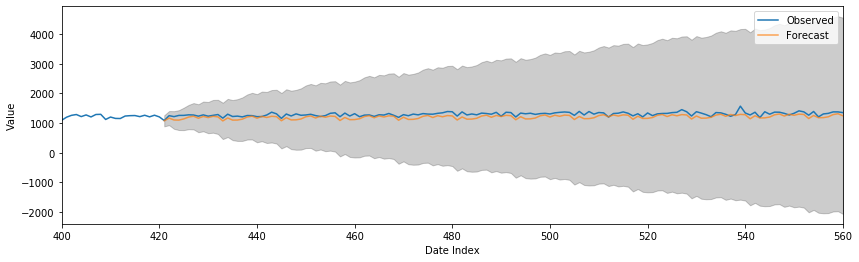

In [25]:
### EXECUTE IN MAIN FUNCTION ###
#Plot the predictions against the real data
plot_results(mean_predicted_values, 
             confidence_interval_predicted_values, 
             df['Geothermal_net_generation'][400:])